In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA


### Read the raw data

In [99]:
from pathlib import Path

def create_country_path_dict(root_dir: str) -> dict[str, str]:
    """
    Recursively finds all CSV files and returns them as a dictionary.

    The dictionary key is the formatted country name (from the filename),
    and the value is the full path to the CSV file.

    Args:
        root_dir: The path to the root directory to start searching from.

    Returns:
        A dictionary mapping formatted country names to their file paths.
    """
    country_path_map = {}
    start_path = Path(root_dir)

    # Use rglob() to find all files matching the pattern '*.csv' recursively
    for file_path in start_path.rglob('*.csv'):
        # Get the filename without the '.csv' extension (e.g., 'south-sudan')
        file_stem = file_path.stem
        
        # Format the stem into a proper name (e.g., 'South Sudan')
        country_name = file_stem.replace('-', ' ').title()
        
        # Add the new key-value pair to the dictionary
        country_path_map[country_name] = str(file_path)
        
        # Sort the dictionary by its keys (the country names)
        sorted_map = dict(sorted(country_path_map.items()))

    return sorted_map

In [100]:
country_list = create_country_path_dict('raw_data/')

### Exploratory Data Analysis

In [101]:
country = 'Indonesia'
country_path = country_list[country]

In [102]:
df = pd.read_csv(country_path)
df.tail()

,Year,Population,Yearly %Change,YearlyChange,Migrants(net),MedianAge,FertilityRate,Density(P/Km²),UrbanPop %,UrbanPopulation,Country'sShare ofWorld Pop,WorldPopulation,IndonesiaGlobalRank
13,2020,274814866,0.98%,2603123,−18743,29.1,2.19,152,56.1%,154188546,3.48%,7887001292,4
14,2022,278830529,0.73%,2007832,−37501,29.6,2.15,154,57.6%,160724456,3.48%,8021407192,4
15,2023,281190067,0.85%,2359538,−37501,29.8,2.13,155,58.3%,163963233,3.48%,8091734930,4
16,2024,283487931,0.82%,2297864,−38469,30.1,2.12,156,59%,167176839,3.47%,8161972572,4
17,2025,285721236,0.79%,2233305,−39509,30.4,2.10,158,59.6%,170361295,3.47%,8231613070,4


#### Data Cleaning

In [103]:
# Check for empty data
df.isnull().sum()

Year                          0
Population                    0
Yearly %Change                0
YearlyChange                  0
Migrants(net)                 0
MedianAge                     0
FertilityRate                 0
Density(P/Km²)                0
UrbanPop %                    0
UrbanPopulation               0
Country'sShare ofWorld Pop    0
WorldPopulation               0
IndonesiaGlobalRank           0
dtype: int64

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        18 non-null     int64  
 1   Population                  18 non-null     int64  
 2   Yearly %Change              18 non-null     object 
 3   YearlyChange                18 non-null     int64  
 4   Migrants(net)               18 non-null     object 
 5   MedianAge                   18 non-null     float64
 6   FertilityRate               18 non-null     float64
 7   Density(P/Km²)              18 non-null     int64  
 8   UrbanPop %                  18 non-null     object 
 9   UrbanPopulation             18 non-null     int64  
 10  Country'sShare ofWorld Pop  18 non-null     object 
 11  WorldPopulation             18 non-null     int64  
 12  IndonesiaGlobalRank         18 non-null     int64  
dtypes: float64(2), int64(7), object(4)
me

In [105]:
# Select all column with dtype = object
object_cols = df.select_dtypes(include='object')

# Convert all object column to numeric
for col in object_cols:
    cleaned_col = object_cols[col].astype(str).str.replace('%', '').str.strip()
    cleaned_col = cleaned_col.str.replace(',', '')
    cleaned_col = cleaned_col.str.replace('−', '-')
    df[col] = pd.to_numeric(cleaned_col, errors='coerce')
    df.fillna(0, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        18 non-null     int64  
 1   Population                  18 non-null     int64  
 2   Yearly %Change              18 non-null     float64
 3   YearlyChange                18 non-null     int64  
 4   Migrants(net)               18 non-null     int64  
 5   MedianAge                   18 non-null     float64
 6   FertilityRate               18 non-null     float64
 7   Density(P/Km²)              18 non-null     int64  
 8   UrbanPop %                  18 non-null     float64
 9   UrbanPopulation             18 non-null     int64  
 10  Country'sShare ofWorld Pop  18 non-null     float64
 11  WorldPopulation             18 non-null     int64  
 12  IndonesiaGlobalRank         18 non-null     int64  
dtypes: float64(5), int64(8)
memory usage:

In [106]:
df.sample(5)

,Year,Population,Yearly %Change,YearlyChange,Migrants(net),MedianAge,FertilityRate,Density(P/Km²),UrbanPop %,UrbanPopulation,Country'sShare ofWorld Pop,WorldPopulation,IndonesiaGlobalRank
14,2022,278830529,0.73,2007832,-37501,29.6,2.15,154,57.6,160724456,3.48,8021407192,4
3,1970,115657495,2.67,2858473,81368,17.9,5.49,64,17.0,19603959,3.13,3694683794,5
4,1975,131843848,2.65,3237271,56386,17.8,5.03,73,19.2,25252096,3.24,4070735277,5
1,1960,88296070,2.70,2204513,101631,19.1,5.50,49,14.5,12805184,2.93,3015470894,6
7,1990,183501098,1.93,3344983,11539,20.6,3.11,101,30.2,55491343,3.44,5327803110,4


#### Correlation Analysis

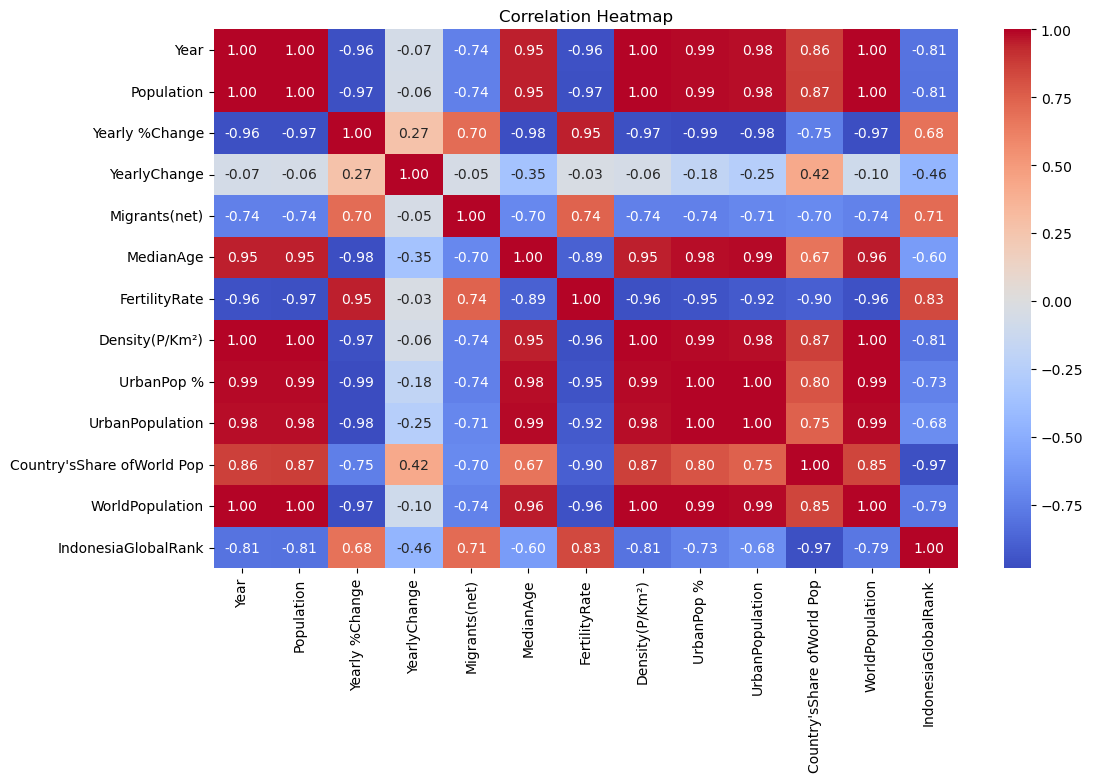

In [107]:
# selected_df = df.
correlation_matrix = df.corr(method='pearson')

plt.figure(figsize=(12, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [108]:
# Exclude Population and Density(P/Km²) from corr matrix. Density is a derivative of Population
selected_matrix = correlation_matrix.drop(['Population', 'Density(P/Km²)'])

# Select column with highest correlation with Population
highest_corr_col = selected_matrix['Population'].abs().idxmax()

print("The highest correlated column with the Population is:", highest_corr_col)

The highest correlated column with the Population is: Year


### Forecasting Future Population

In [109]:
def manual_linear_regression(x_values, y_values):
    """
    Returns:
      A tuple containing the y-intercept (a) and the slope (b).
      Returns (None, None) if the input lists are invalid.
    """
    # Input Validation
    if (len(x_values) == 0 or len(y_values) == 0):
        print("Error: Input lists cannot be empty.")
        return None, None
    
    if len(x_values) != len(y_values):
        print("Error: Input lists must have the same number of elements.")
        return None, None

    n = len(x_values)        

    # Calculate the means
    x_mean = sum(x_values) / n
    y_mean = sum(y_values) / n

    # Calculate the terms for the slope formula
    # The formula for the slope (b) is:
    # b = Σ( (x_i - x_mean) * (y_i - y_mean) ) / Σ( (x_i - x_mean)^2 )

    numerator = 0
    denominator = 0

    for i in range(n):
        numerator += (x_values[i] - x_mean) * (y_values[i] - y_mean)
        denominator += (x_values[i] - x_mean) ** 2

    # Calculate the slope (b)
    # Handle the edge case where all x_values are the same, to avoid division by zero.
    if denominator == 0:
        print("Warning: Cannot calculate a unique slope because all x-values are the same.")
        slope = 0
    else:
        slope = numerator / denominator

    # Calculate the y-intercept (a)
    # The formula for the y-intercept (a) is: a = y_mean - b * x_mean
    intercept = y_mean - slope * x_mean

    return intercept, slope

In [110]:
# Forecast Future highest_corr_col based on Year
x_year = df['Year']
y_highest_corr_col = df[highest_corr_col]

# Build the model: highest_corr_col = a + b * Year
intercept_highest_corr, slope_highest_corr = manual_linear_regression(x_year, y_highest_corr_col)

# Generate 5 future years to forecast
last_year = df['Year'].max()
future_years = [last_year + i for i in range(1, 11)]

# Predict highest_corr_col for the future years using the first model
future_highest_corr_cols = [intercept_highest_corr + slope_highest_corr * year for year in future_years]
print("Future " + highest_corr_col + " forecast created.")


# Use the highest_corr_col Forecast to Predict Future Total Population
x_highest_corr_col = df[highest_corr_col]
y_population = df['Population']

# Build the main model: Population = a + b * highest_corr_col
intercept_pop, slope_pop = manual_linear_regression(x_highest_corr_col, y_population)

# Use the forecasted highest_corr_col to predict the final total population
future_population_forecast = [intercept_pop + slope_pop * highest_corr_col for highest_corr_col in future_highest_corr_cols]
print("Final Total Population forecast complete.")


# Present the Results
forecast_df = pd.DataFrame({
    'Year': future_years,
    'Forecasted Urban Population': [int(p) for p in future_highest_corr_cols],
    'Forecasted Total Population': [int(p) for p in future_population_forecast]
})

print("\n--- " + country + " Population Forecast (Next 10 Years) ---")
print(forecast_df.to_string(index=False))

Future Year forecast created.
Final Total Population forecast complete.

--- Indonesia Population Forecast (Next 10 Years) ---
 Year  Forecasted Urban Population  Forecasted Total Population
 2026                         2026                    292661129
 2027                         2027                    295749015
 2028                         2028                    298836902
 2029                         2029                    301924789
 2030                         2030                    305012675
 2031                         2031                    308100562
 2032                         2032                    311188448
 2033                         2033                    314276335
 2034                         2034                    317364222
 2035                         2035                    320452108


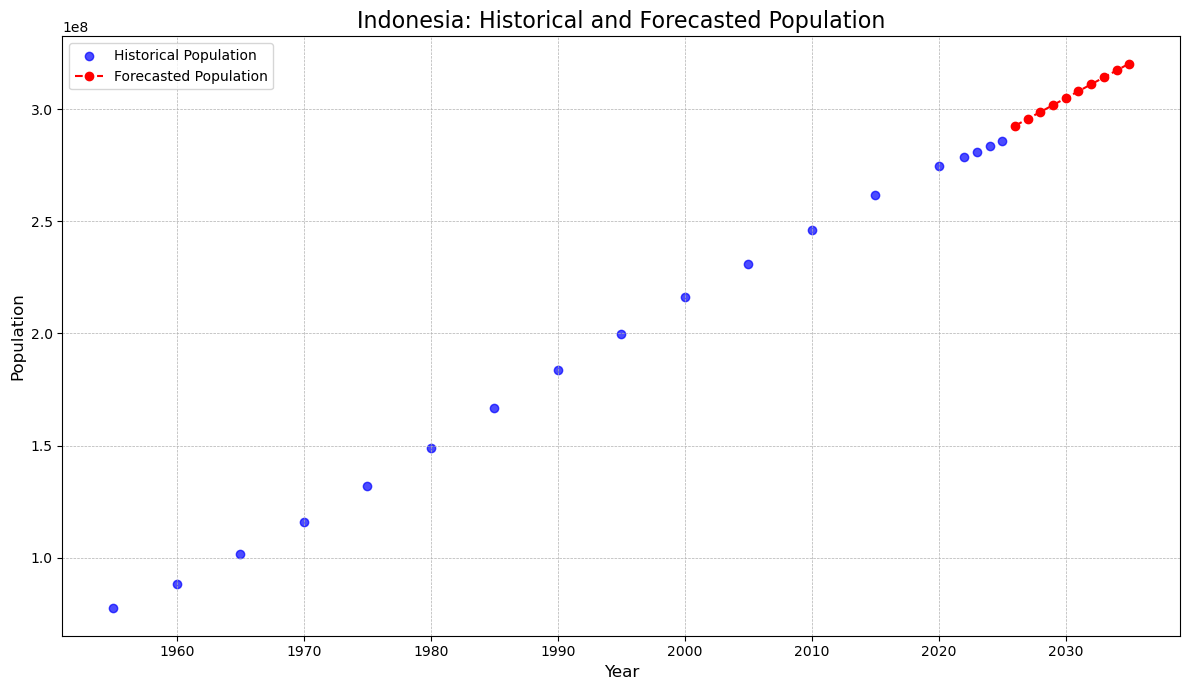

In [111]:
# Visualization
plt.figure(figsize=(12, 7))

# Plot historical data points
plt.scatter(df['Year'], df['Population'], color='blue', label='Historical Population', alpha=0.7)

# Plot forecasted data points
plt.plot(forecast_df['Year'], forecast_df['Forecasted Total Population'], color='red', marker='o', linestyle='--', label='Forecasted Population')

plt.title(country + ': Historical and Forecasted Population', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Population', fontsize=12)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [112]:
df.tail()

,Year,Population,Yearly %Change,YearlyChange,Migrants(net),MedianAge,FertilityRate,Density(P/Km²),UrbanPop %,UrbanPopulation,Country'sShare ofWorld Pop,WorldPopulation,IndonesiaGlobalRank
13,2020,274814866,0.98,2603123,-18743,29.1,2.19,152,56.1,154188546,3.48,7887001292,4
14,2022,278830529,0.73,2007832,-37501,29.6,2.15,154,57.6,160724456,3.48,8021407192,4
15,2023,281190067,0.85,2359538,-37501,29.8,2.13,155,58.3,163963233,3.48,8091734930,4
16,2024,283487931,0.82,2297864,-38469,30.1,2.12,156,59.0,167176839,3.47,8161972572,4
17,2025,285721236,0.79,2233305,-39509,30.4,2.10,158,59.6,170361295,3.47,8231613070,4


In [113]:
# Calculate All Error Rates

# Error for Model 1: Year to highest correlated column
print(f"--- [1] Error for Model 1: Year -> {highest_corr_col} ---")
y1_predicted = intercept_highest_corr + slope_highest_corr * x_year
mae1 = np.mean(np.abs(y_highest_corr_col - y1_predicted))
mse1 = np.mean((y_highest_corr_col - y1_predicted)**2)
rmse1 = np.sqrt(mse1)
mape1 = np.mean(np.abs((y_highest_corr_col - y1_predicted) / y_highest_corr_col)) * 100
print(f"Mean Absolute Error (MAE): {mae1:,.2f}")
print(f"Mean Squared Error (MSE): {mse1:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse1:,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape1:.2f}%\n")


# Error for Model 2 (Idealized): highest correlated column to population
print(f"--- [2] Error for Model 2 (Idealized): {highest_corr_col} -> Population ---")
print("(This assumes perfect input for the second model)\n")
y2_predicted_ideal = intercept_pop + slope_pop * x_highest_corr_col # Using actual data as input
mae2 = np.mean(np.abs(y_population - y2_predicted_ideal))
mse2 = np.mean((y_population - y2_predicted_ideal)**2)
rmse2 = np.sqrt(mse2)
mape2 = np.mean(np.abs((y_population - y2_predicted_ideal) / y_population)) * 100
print(f"Mean Absolute Error (MAE): {mae2:,.0f}")
print(f"Mean Squared Error (MSE): {mse2:,.0f}")
print(f"Root Mean Squared Error (RMSE): {rmse2:,.0f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape2:.2f}%\n")


# Total System Error (Compounded)
print("--- [3] Total System Error (Compounded) ---")
print("(This shows the real-world error of the combined two-step forecast)\n")
# Use the PREDICTED values from Model 1 (y1_predicted) as the input for Model 2
final_predicted_population = intercept_pop + slope_pop * y1_predicted
actual_population = y_population

# Calculate final error metrics
final_mae = np.mean(np.abs(actual_population - final_predicted_population))
final_mse = np.mean((actual_population - final_predicted_population)**2)
final_rmse = np.sqrt(final_mse)
final_mape = np.mean(np.abs((actual_population - final_predicted_population) / actual_population)) * 100

print(f"Mean Absolute Error (MAE): {final_mae:,.0f}")
print(f"Mean Squared Error (MSE): {final_mse:,.0f}")
print(f"Root Mean Squared Error (RMSE): {final_rmse:,.0f}")
print(f"Mean Absolute Percentage Error (MAPE): {final_mape:.2f}%")


--- [1] Error for Model 1: Year -> Year ---
Mean Absolute Error (MAE): 0.00
Mean Squared Error (MSE): 0.00
Root Mean Squared Error (RMSE): 0.00
Mean Absolute Percentage Error (MAPE): 0.00%

--- [2] Error for Model 2 (Idealized): Year -> Population ---
(This assumes perfect input for the second model)

Mean Absolute Error (MAE): 2,568,911
Mean Squared Error (MSE): 7,828,693,079,778
Root Mean Squared Error (RMSE): 2,797,980
Mean Absolute Percentage Error (MAPE): 1.56%

--- [3] Total System Error (Compounded) ---
(This shows the real-world error of the combined two-step forecast)

Mean Absolute Error (MAE): 2,568,911
Mean Squared Error (MSE): 7,828,693,079,778
Root Mean Squared Error (RMSE): 2,797,980
Mean Absolute Percentage Error (MAPE): 1.56%


### Prototype

#### Defining Function

In [114]:
## Clean data
def clean_data(df):
  # Select all column with dtype = object
  object_cols = df.select_dtypes(include='object')

  # Convert all object column to numeric
  for col in object_cols:
      cleaned_col = object_cols[col].astype(str).str.replace('%', '').str.strip()
      cleaned_col = cleaned_col.str.replace(',', '')
      cleaned_col = cleaned_col.str.replace('−', '-')
      df[col] = pd.to_numeric(cleaned_col, errors='coerce')
      df.fillna(0, inplace=True)

In [115]:
def find_highest_correlation(df, reference_column, exclude_cols=None):
    # Input Validation
    if reference_column not in df.columns:
        print(f"Error: Reference column '{reference_column}' not found in the DataFrame.")
        return None

    # Select only numeric columns for correlation calculation
    numeric_df = df.select_dtypes(include=np.number)

    if reference_column not in numeric_df.columns:
        print(f"Error: Reference column '{reference_column}' is not a numeric type.")
        return None

    if exclude_cols:
        # Create a list of columns to drop that actually exist in the numeric DataFrame
        cols_to_drop = [col for col in exclude_cols if col in numeric_df.columns]
        numeric_df = numeric_df.drop(columns=cols_to_drop)

    corr_matrix = numeric_df.corr()

    # Get correlations with the reference column ---
    corr_with_ref = corr_matrix[reference_column]

    # We drop the reference column itself
    corr_with_ref = corr_with_ref.drop(reference_column)

    # Check if there are any columns left to compare
    if corr_with_ref.empty:
        print("Warning: No other columns available for correlation comparison.")
        return None

    # We use .abs() to find the strongest relationship, whether positive or negative.
    highest_corr_col = corr_with_ref.abs().idxmax()

    return highest_corr_col

In [116]:
def forecast_with_linear_regression(df, years_to_predict, selected_country_name):
  # Find the best feature to use alongside 'Year'
  exclude_list = ['Year', 'Density(P/Km²)']
  best_feature = find_highest_correlation(df, 'Population', exclude_cols=exclude_list)

  if not best_feature:
    print("Could not find a suitable feature for correlation. Defaulting to 'Year'.")
    features_to_use = ['Year']
  else:
    print(f"Highest correlation with 'Population' is '{best_feature}'.")
    print("Using 'Year' and '{}' for the model.".format(best_feature))
    features_to_use = ['Year', best_feature]

  print("---------------------------------")

  # Create a future DataFrame for prediction. It must contain ALL features used in training.
  last_year = df['Year'].max()
  start_year = last_year + 1
  end_year = start_year + years_to_predict
  future_df = pd.DataFrame({'Year': np.arange(start_year, end_year)})

  # Define our features (X) and target (y)
  x_train = df[features_to_use]
  y_train = df['Population']

  # Train the model on our selected features
  model_lr = LinearRegression()
  model_lr.fit(x_train, y_train)

  # If we used a second feature, we must estimate its future values.
  if best_feature and best_feature != 'Year':
    # A simple way is to use a linear trend from the historical data
    last_feature_val = df[best_feature].iloc[-1]
    feature_trend = df[best_feature].diff().mean() # Average change per year
    future_feature_vals = [last_feature_val + feature_trend * i for i in range(1, years_to_predict + 1)]
    future_df[best_feature] = future_feature_vals

  # Predict using the future DataFrame that contains ALL required features
  pop_forecast_lr = model_lr.predict(future_df[features_to_use])

  print("Forecasted Population:")
  # Use the 'Year' column from our future_df for the results table
  results_df = pd.DataFrame({
    'Year': future_df['Year'],
    'Predicted_Population': pop_forecast_lr.astype(int)
  })
  print(results_df)
  print("---------------------------------")

  # Visualisasi
  plt.figure(figsize=(12, 6))
  plt.plot(df['Year'], df['Population'], label='Historical Data', marker='o')
  plt.plot(future_df['Year'], pop_forecast_lr, label='Multivariate Forecast', marker='x', linestyle='--')
  plt.title(f'{selected_country_name} Population Forecast')
  plt.xlabel('Year', fontsize=12)
  plt.ylabel('Population', fontsize=12)
  plt.legend()
  plt.grid(True, which='both', linestyle='--', linewidth=0.5)
  plt.tight_layout()
  plt.show()

In [117]:
def forecast_with_arima(df, years_to_predict, selected_country_name):
  time_series_df = df[['Year', 'Population']].copy()

  # The 'Year' column must be the index for the time series model.
  time_series_df['Year'] = pd.to_datetime(time_series_df['Year'], format='%Y')
  time_series_df.set_index('Year', inplace=True)

  # To handle potential warnings, we can set the frequency of the index
  time_series_df = time_series_df.asfreq('YS-JAN') # Annual, Start of January

  # Fit the ARIMA Model
  # The order (p,d,q) is a key parameter for ARIMA.
  # (5,1,0) is a common starting point for yearly data.
  model = ARIMA(time_series_df['Population'], order=(5, 1, 0))
  model_fit = model.fit()

  # Forecast Future Values
  forecast_result = model_fit.forecast(steps=years_to_predict)

  # Manually create the future years for the DataFrame
  last_year = time_series_df.index.max().year
  future_years = np.arange(last_year + 1, last_year + 1 + years_to_predict)

  # Create a DataFrame for the results using our manually created years
  forecast_df = pd.DataFrame({
      'Year': future_years,
      'Predicted_Population': forecast_result.values.astype(int)
  })

  print("Forecasted Population:")
  print(forecast_df)
  print("---------------------------------")

  # Visualization
  plt.figure(figsize=(12, 6))
  plt.plot(time_series_df.index.year, time_series_df['Population'], label='Historical Data', marker='o')
  plt.plot(forecast_df['Year'], forecast_df['Predicted_Population'], label='ARIMA Forecast', marker='x', linestyle='--')
  plt.title(f'{selected_country_name} Population Forecast (ARIMA)')
  plt.xlabel('Year', fontsize=12)
  plt.ylabel('Population', fontsize=12)
  plt.legend()
  plt.grid(True, which='both', linestyle='--', linewidth=0.5)
  plt.tight_layout()
  plt.show()

#### Create Display

In [ ]:
import ipywidgets as widgets
from IPython.display import display

dropdown = widgets.Dropdown(
    options=country_list,
    description='Regions:'
)

output_area = widgets.Output()

total_year = widgets.IntSlider(
    value=5, min=1, max=20, step=1,
    description='Jumlah Tahun Prediksi:',
    style={'description_width': 'initial'}
)

button = widgets.Button(
    description='Show Prediction',
    button_style='success',
    tooltip='Click to run the prediction with the selected options',
    icon='play'
)

output_area = widgets.Output()

In [119]:
def show_prediction(b):
  selected_country_name = dropdown.label.title()
  selected_country_path = dropdown.value
  years_to_predict = total_year.value

  try:
    df = pd.read_csv(selected_country_path)
  except Exception as e:
    print(f"Error reading the file: {e}")
    return

  with output_area:
    output_area.clear_output()
    print(f"Selected Country: {selected_country_name}")
    print(f"Years to Predict: {years_to_predict}")
    print("---------------------------------")

    df = pd.read_csv(selected_country_path)
    clean_data(df)

    print("\n### Using Linear Regression Model ###\n")
    forecast_with_linear_regression(df, years_to_predict, selected_country_name)

    print("\n\n### Using ARIMA Model ###")
    forecast_with_arima(df, years_to_predict, selected_country_name)


#### Demo

In [120]:
print("Forecast by nation")
button.on_click(show_prediction)
display(dropdown, total_year, button, output_area)

Forecast by nation


Dropdown(description='Regions:', options={'Afghanistan': 'raw_data\\asia\\southern-asia\\afghanistan.csv', 'Al…

IntSlider(value=5, description='Jumlah Tahun Prediksi:', max=20, min=1, style=SliderStyle(description_width='i…

Button(button_style='success', description='Show Prediction', icon='play', style=ButtonStyle(), tooltip='Click…

Output()

#### Testing

In [121]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA

def forecast_linear_library(x, y):
    model = LinearRegression()
    model.fit(x, y)
    future_years = pd.DataFrame({'Year': np.arange(2026, 2036)})
    forecast = model.predict(future_years)
    return future_years['Year'], forecast

def forecast_linear_manual(x, y):
    n = len(x)
    x_bar = sum(x) / n
    y_bar = sum(y) / n
    num = sum((x[i] - x_bar) * (y[i] - y_bar) for i in range(n))
    den = sum((x[i] - x_bar) ** 2 for i in range(n))
    b = num / den
    a = y_bar - b * x_bar
    pred = [a + b * t for t in range(2026, 2036)]
    return list(range(2026, 2036)), pred

def forecast_arima_library(df):
    model = ARIMA(df['Population'], order=(2,2,1))
    result = model.fit()
    pred = result.forecast(steps=10)
    return list(range(2026, 2036)), pred

def forecast_arima_manual(df):
    y = df['Population'].values
    diff = np.diff(y)
    if len(diff) < 1:
        return [], []
    mean_diff = np.mean(diff[-min(5, len(diff)):])
    last_val = y[-1]
    preds = [last_val + (i+1)*mean_diff for i in range(10)]
    return list(range(2026, 2036)), preds